# An Introduction to SageMaker LDA

***Finding topics in synthetic document data using Spectral LDA algorithms.***

---

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Training](#Training)
1. [Inference](#Inference)
1. [Epilogue](#Epilogue)

# Introduction
***

Amazon SageMaker LDA is an unsupervised learning algorithm that attempts to describe a set of observations as a mixture of distinct categories. Latent Dirichlet Allocation (LDA) is most commonly used to discover a user-specified number of topics shared by documents within a text corpus. Here each observation is a document, the features are the presence (or occurrence count) of each word, and the categories are the topics. Since the method is unsupervised, the topics are not specified up front, and are not guaranteed to align with how a human may naturally categorize documents. The topics are learned as a probability distribution over the words that occur in each document. Each document, in turn, is described as a mixture of topics.

In this notebook we will use the Amazon SageMaker LDA algorithm to train an LDA model on some example synthetic data. We will then use this model to classify (perform inference on) the data. The main goals of this notebook are to,

* learn how to obtain and store data for use in Amazon SageMaker,
* create an AWS SageMaker training job on a data set to produce an LDA model,
* use the LDA model to perform inference with an Amazon SageMaker endpoint.

The following are ***not*** goals of this notebook:

* understand the LDA model,
* understand how the Amazon SageMaker LDA algorithm works,
* interpret the meaning of the inference output

If you would like to know more about these things take a minute to run this notebook and then check out the SageMaker LDA Documentation and the **LDA-Science.ipynb** notebook.

In [1]:
!conda install -y scipy

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.6.14

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/mxnet_p36

  added / updated specs: 
    - scipy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    mkl_fft-1.0.12             |   py36ha843d7b_0         172 KB
    mkl-2019.3                 |              199       203.3 MB
    mkl_random-1.0.2           |   py36hd81dba3_0         407 KB
    numpy-base-1.16.3          |   py36hde5b4d6_0         4.4 MB
    mkl-service-1.1.2          |   py36he904b0f_5         132 KB
    numpy-1.16.3               |   py36h7e9f1db_0          49 KB
    numexpr-2.6.9              |   py36h9e4a6bb_0         194 KB
    scipy-1.2.1                |   py36h7c811a0_0        17.7 MB
 

In [19]:
%matplotlib inline

import os, re

import boto3
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# some helpful utility functions are defined in the Python module
# "generate_example_data" located in the same directory as this
# notebook
from generate_example_data import generate_griffiths_data, plot_lda, match_estimated_topics

# accessing the SageMaker Python SDK
import sagemaker
from sagemaker.amazon.common import numpy_to_record_serializer
from sagemaker.predictor import csv_serializer, json_deserializer

# Setup

***

*This notebook was created and tested on an ml.m4.xlarge notebook instance.*

Before we do anything at all, we need data! We also need to setup our AWS credentials so that AWS SageMaker can store and access data. In this section we will do four things:

1. [Setup AWS Credentials](#SetupAWSCredentials)
1. [Obtain Example Dataset](#ObtainExampleDataset)
1. [Inspect Example Data](#InspectExampleData)
1. [Store Data on S3](#StoreDataonS3)

## Setup AWS Credentials

We first need to specify some AWS credentials; specifically data locations and access roles. This is the only cell of this notebook that you will need to edit. In particular, we need the following data:

* `bucket` - An S3 bucket accessible by this account.
  * Used to store input training data and model data output.
  * Should be withing the same region as this notebook instance, training, and hosting.
* `prefix` - The location in the bucket where this notebook's input and and output data will be stored. (The default value is sufficient.)
* `role` - The IAM Role ARN used to give training and hosting access to your data.
  * See documentation on how to create these.
  * The script below will try to determine an appropriate Role ARN.

In [69]:
import pandas as pd

# get the data set from S3

#!mkdir Data
#!aws s3 cp s3://sagemaker-us-east-1-023375022819/alex-jackson/topic-modeling/amazon_review_polarity_csv.tgz Data
#!tar -xvzf Data/amazon_review_polarity_csv.tgz


In [70]:
#read it into a dataframe and filter out the good reviews
df = pd.read_csv("amazon_review_polarity_csv/train.csv", names=["Label", "Title", "Review"])
negative_df = df[df["Label"] == 1]

In [71]:
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
stop_words.add("n't")
stop_words.add("'s")
stop_words.add("would")
stop_words.add("like")
stop_words.add("''")
stop_words.add("``")
stop_words.add("get")
stop_words.add("...")
stop_words.add("could")
stop_words.add("really")
stop_words.add("much")
stop_words.add("'m")
stop_words.add("'ve'")
stop_words.add("'ve")

#function to count words that we care about
def countWords(row):
    wordCount = {}
    for word in nltk.word_tokenize(row.lower()):
        if word not in stop_words and word not in string.punctuation:
            if word not in wordCount:
                wordCount[word] = 0
            wordCount[word]+=1
    return wordCount

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [72]:
import multiprocessing
from multiprocessing import Pool
pool = Pool(processes=multiprocessing.cpu_count())

all_rows = [row for row in negative_df["Review"]]
all_rows = all_rows[:int(0.1*len(all_rows))]
#count words in parallel
transformed_rows = pool.map(countWords, all_rows)
pool.close() 
pool.join()

180000


In [74]:
print(transformed_rows[0])

{'self-published': 1, 'book': 5, 'want': 1, 'know': 1, '--': 5, 'read': 1, 'paragraphs': 1, '5': 1, 'star': 1, 'reviews': 1, 'must': 1, 'written': 1, 'ms.': 2, 'haddon': 2, 'family': 1, 'friends': 1, 'perhaps': 1, 'ca': 2, 'imagine': 1, 'anyone': 1, 'reading': 2, 'whole': 1, 'thing': 2, 'spent': 1, 'evening': 1, 'friend': 1, 'hysterics': 1, 'bits': 1, 'pieces': 1, 'one': 2, 'another': 1, 'definitely': 1, 'bad': 1, 'enough': 1, 'entered': 1, 'kind': 2, 'worst': 1, 'contest': 1, 'believe': 1, 'amazon': 1, 'even': 1, 'sells': 1, 'maybe': 1, 'offer': 1, '8th': 1, 'grade': 1, 'term': 1, 'paper': 1, 'kill': 1, 'mockingbird': 1, 'quite': 1, 'sure': 1, 'never': 1, 'heard': 1, 'anyway': 1, 'unless': 1, 'mood': 1, 'send': 1, 'someone': 1, 'joke': 1, '-stay': 1, 'far': 2, 'away': 1}


In [75]:
#get word counts on all documents - reduce the results from the parallel processing into a single table
wordTable = {}
for row in transformed_rows:
    for key in row:
        if key not in wordTable:
            wordTable[key] = 0
        wordTable[key] += 1

In [76]:
#take only the top 25 words
import operator
sorted_frequency = sorted(wordTable.items(), key=operator.itemgetter(1), reverse=True)


In [77]:
print(sorted_frequency[:20])

[('one', 50230), ('book', 45916), ('good', 32237), ('time', 28548), ('even', 27264), ('read', 24778), ('movie', 23107), ('first', 22416), ('buy', 20055), ('better', 19921), ('money', 19123), ('great', 18508), ('bought', 17429), ('well', 16485), ('bad', 16390), ('way', 16181), ('never', 15840), ('think', 15654), ('back', 15589), ('make', 15485)]


In [78]:
#generate a lookup table to get an int value for a word
wordLookup = {}
for idx, word in enumerate(sorted_frequency):
    wordLookup[word] = idx
print(len(wordTable))

246554


In [79]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket = 'sagemaker-us-east-1-023375022819'
prefix = 'alex-jackson/topic-modeling/LDA'

print('Training input/output will be stored in {}/{}'.format(bucket, prefix))
print('\nIAM Role: {}'.format(role))

Training input/output will be stored in sagemaker-us-east-1-023375022819/alex-jackson/topic-modeling/LDA

IAM Role: arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20190507T153260


In [80]:
#create a table where each row is made up of counts of the word for each column
training = []
for row in transformed_rows:
    counts = [0 for x in range(20)]
    for key in row:
        wordInt = wordTable[key]
        if wordInt < 20:
            counts[wordInt] = row[key]
    training.append(counts)


In [81]:
import pandas as pd

transformed_df = pd.DataFrame(training)
transformed_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,1,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [82]:
transformed_df[:25]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,1,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,1,0,1,0,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
9,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Obtain Example Data


We generate some example synthetic document data. For the purposes of this notebook we will omit the details of this process. All we need to know is that each piece of data, commonly called a *"document"*, is a vector of integers representing *"word counts"* within the document. In this particular example there are a total of 25 words in the *"vocabulary"*.

$$
\underbrace{w}_{\text{document}} = \overbrace{\big[ w_1, w_2, \ldots, w_V \big] }^{\text{word counts}},
\quad
V = \text{vocabulary size}
$$

These data are based on that used by Griffiths and Steyvers in their paper [Finding Scientific Topics](http://psiexp.ss.uci.edu/research/papers/sciencetopics.pdf). For more information, see the **LDA-Science.ipynb** notebook.

In [83]:
print('Generating example data...')
num_documents = 6000
num_topics = 10
known_alpha, known_beta, documents, topic_mixtures = generate_griffiths_data(
    num_documents=num_documents, num_topics=num_topics)
vocabulary_size = len(documents[0])

# separate the generated data into training and tests subsets
num_documents_training = int(0.9*num_documents)
num_documents_test = num_documents - num_documents_training

documents_training = documents[:num_documents_training]
documents_test = documents[num_documents_training:]

topic_mixtures_training = topic_mixtures[:num_documents_training]
topic_mixtures_test = topic_mixtures[num_documents_training:]

print('documents_training.shape = {}'.format(documents_training.shape))
print('documents_test.shape = {}'.format(documents_test.shape))

Generating example data...
documents_training.shape = (5400, 25)
documents_test.shape = (600, 25)


## Inspect Example Data

*What does the example data actually look like?* Below we print an example document as well as its corresponding known *topic-mixture*. A topic-mixture serves as the "label" in the LDA model. It describes the ratio of topics from which the words in the document are found.

For example, if the topic mixture of an input document $\mathbf{w}$ is,

$$\theta = \left[ 0.3, 0.2, 0, 0.5, 0 \right]$$

then $\mathbf{w}$ is 30% generated from the first topic, 20% from the second topic, and 50% from the fourth topic. For more information see **How LDA Works** in the SageMaker documentation as well as the **LDA-Science.ipynb** notebook.

Below, we compute the topic mixtures for the first few training documents. As we can see, each document is a vector of word counts from the 25-word vocabulary and its topic-mixture is a probability distribution across the five topics used to generate the sample dataset.

In [84]:
print('First training document =\n{}'.format(documents[0]))
print('\nVocabulary size = {}'.format(vocabulary_size))

First training document =
[ 0.  0.  3.  0.  0. 13. 10. 13. 12.  7. 13. 20. 17. 26. 21.  0.  1.  3.
  0.  1.  0.  0.  2.  0.  0.]

Vocabulary size = 25


In [85]:
print('Known topic mixture of first document =\n{}'.format(topic_mixtures_training[0]))
print('\nNumber of topics = {}'.format(num_topics))
print('Sum of elements = {}'.format(topic_mixtures_training[0].sum()))

Known topic mixture of first document =
[0.    0.021 0.076 0.    0.002 0.    0.299 0.594 0.006 0.003]

Number of topics = 10
Sum of elements = 1.0


Later, when we perform inference on the training data set we will compare the inferred topic mixture to this known one.

---

Human beings are visual creatures, so it might be helpful to come up with a visual representation of these documents. In the below plots, each pixel of a document represents a word. The greyscale intensity is a measure of how frequently that word occurs. Below we plot the first few documents of the training set reshaped into 5x5 pixel grids.

In [86]:
import numpy as np
%matplotlib inline

documents_training = np.array(transformed_df[:54000])
#fig = plot_lda(np.array(transformed_df[:5400]), nrows=3, ncols=4, cmap='gray_r', with_colorbar=True)
#fig.suptitle('Example Document Word Counts')
#fig.set_dpi(160)

## Store Data on S3

A SageMaker training job needs access to training data stored in an S3 bucket. Although training can accept data of various formats we convert the documents MXNet RecordIO Protobuf format before uploading to the S3 bucket defined at the beginning of this notebook. We do so by making use of the SageMaker Python SDK utility `numpy_to_record_serializer`.

In [87]:
# convert documents_training to Protobuf RecordIO format
recordio_protobuf_serializer = numpy_to_record_serializer()
fbuffer = recordio_protobuf_serializer(documents_training)

# upload to S3 in bucket/prefix/train
fname = 'lda.data'
s3_object = os.path.join(prefix, 'train', fname)
boto3.Session().resource('s3').Bucket(bucket).Object(s3_object).upload_fileobj(fbuffer)

s3_train_data = 's3://{}/{}'.format(bucket, s3_object)
print('Uploaded data to S3: {}'.format(s3_train_data))

Uploaded data to S3: s3://sagemaker-us-east-1-023375022819/alex-jackson/topic-modeling/LDA/train/lda.data


# Training

***

Once the data is preprocessed and available in a recommended format the next step is to train our model on the data. There are number of parameters required by SageMaker LDA configuring the model and defining the computational environment in which training will take place.

First, we specify a Docker container containing the SageMaker LDA algorithm. For your convenience, a region-specific container is automatically chosen for you to minimize cross-region data communication. Information about the locations of each SageMaker algorithm is available in the documentation.

In [88]:
from sagemaker.amazon.amazon_estimator import get_image_uri
# select the algorithm container based on this notebook's current location

region_name = boto3.Session().region_name
container = get_image_uri(region_name, 'lda')

print('Using SageMaker LDA container: {} ({})'.format(container, region_name))

Using SageMaker LDA container: 766337827248.dkr.ecr.us-east-1.amazonaws.com/lda:1 (us-east-1)


Particular to a SageMaker LDA training job are the following hyperparameters:

* **`num_topics`** - The number of topics or categories in the LDA model.
  * Usually, this is not known a priori.
  * In this example, howevever, we know that the data is generated by five topics.

* **`feature_dim`** - The size of the *"vocabulary"*, in LDA parlance.
  * In this example, this is equal 25.

* **`mini_batch_size`** - The number of input training documents.

* **`alpha0`** - *(optional)* a measurement of how "mixed" are the topic-mixtures.
  * When `alpha0` is small the data tends to be represented by one or few topics.
  * When `alpha0` is large the data tends to be an even combination of several or many topics.
  * The default value is `alpha0 = 1.0`.

In addition to these LDA model hyperparameters, we provide additional parameters defining things like the EC2 instance type on which training will run, the S3 bucket containing the data, and the AWS access role. Note that,

* Recommended instance type: `ml.c4`
* Current limitations:
  * SageMaker LDA *training* can only run on a single instance.
  * SageMaker LDA does not take advantage of GPU hardware.
  * (The Amazon AI Algorithms team is working hard to provide these capabilities in a future release!)

In [89]:
session = sagemaker.Session()

# specify general training job information
lda = sagemaker.estimator.Estimator(
    container,
    role,
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    sagemaker_session=session,
)

# set algorithm-specific hyperparameters
lda.set_hyperparameters(
    num_topics=num_topics,
    feature_dim=20,
    mini_batch_size=54000,
    alpha0=1.0,
)

# run the training job on input data stored in S3
lda.fit({'train': s3_train_data})

2019-05-09 14:02:02 Starting - Starting the training job...
2019-05-09 14:02:06 Starting - Launching requested ML instances.........
2019-05-09 14:03:45 Starting - Preparing the instances for training......
2019-05-09 14:04:45 Downloading - Downloading input data...
2019-05-09 14:05:33 Training - Training image download completed. Training in progress.
2019-05-09 14:05:33 Uploading - Uploading generated training model.
Docker entrypoint called with argument(s): train
Using mxnet backend.
[05/09/2019 14:05:30 INFO 139738506196800] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'alpha0': u'1.0', u'max_restarts': u'10', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'allow_svd_init': u'true', u'epochs': u'1', u'tol': u'1e-8', u'_kvstore': u'local', u'max_iterations': u'1000'}
[05/09/2019 14:05:30 INFO 139738506196800] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_di


2019-05-09 14:05:41 Completed - Training job completed
Billable seconds: 56


If you see the message

> `===== Job Complete =====`

at the bottom of the output logs then that means training sucessfully completed and the output LDA model was stored in the specified output path. You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab and select training job matching the training job name, below:

In [90]:
print('Training job name: {}'.format(lda.latest_training_job.job_name))

Training job name: lda-2019-05-09-14-02-02-249


# Inference

***

A trained model does nothing on its own. We now want to use the model we computed to perform inference on data. For this example, that means predicting the topic mixture representing a given document.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up.

In [153]:
lda_inference = lda.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',  # LDA inference may work better at scale on ml.c4 instances
)

---------------------------------------------------------------------------------------------------!

Congratulations! You now have a functioning SageMaker LDA inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console and selecting the endpoint matching the endpoint name, below: 

In [92]:
print('Endpoint name: {}'.format(lda_inference.endpoint))

Endpoint name: lda-2019-05-09-14-02-02-249


With this realtime endpoint at our fingertips we can finally perform inference on our training and test data.

We can pass a variety of data formats to our inference endpoint. In this example we will demonstrate passing CSV-formatted data. Other available formats are JSON-formatted, JSON-sparse-formatter, and RecordIO Protobuf. We make use of the SageMaker Python SDK utilities `csv_serializer` and `json_deserializer` when configuring the inference endpoint.

In [93]:
lda_inference.content_type = 'text/csv'
lda_inference.serializer = csv_serializer
lda_inference.deserializer = json_deserializer

In [94]:
df = pd.read_csv("amazon_review_polarity_csv/test.csv", names=["Label", "Title", "Review"])
negative_df = df[df["Label"] == 1]

In [95]:
pool = Pool(processes=multiprocessing.cpu_count())

all_rows = [row for row in negative_df["Review"]]
all_rows = all_rows[:int(0.1*len(all_rows))]
print(len(all_rows))
transformed_rows = pool.map(countWords, all_rows)
pool.close() 
pool.join()

test = []
for row in transformed_rows:
    counts = [0 for x in range(20)]
    for key in row:
        if key in wordTable:
            wordInt = wordTable[key]
            if wordInt < 20:
                counts[wordInt] = row[key]
    test.append(counts)
test_df = pd.DataFrame(test)

documents_test = np.array(test_df[:2000])

20000


We pass some test documents to the inference endpoint. Note that the serializer and deserializer will atuomatically take care of the datatype conversion from Numpy NDArrays.

{'predictions': [{'topic_mixture': [0.8078678250312805, 0.19213218986988068, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [0.5924496650695801, 0.4075503349304199, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [0.5924496650695801, 0.4075503349304199, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [0.45329615473747253, 0.5467038154602051, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [0.5286481976509094, 0.0, 0.0, 0.47135186195373535, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [0.5924496650695801, 0.4075503349304199, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [0.0, 0.0, 0.0, 0.0, 0.0, 0.37555477023124695, 0.0, 0.0, 0.6244452595710754, 0.0]}, {'topic_mixture': [0.5924496650695801, 0.4075503349304199, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [0.4327521026134491, 0.0, 0.0, 0.5672479271888733, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'topic_mixture': [0.5924496650695801, 0.4075503349304199, 0.0, 0.0, 0

It may be hard to see but the output format of SageMaker LDA inference endpoint is a Python dictionary with the following format.

```
{
  'predictions': [
    {'topic_mixture': [ ... ] },
    {'topic_mixture': [ ... ] },
    {'topic_mixture': [ ... ] },
    ...
  ]
}
```

We extract the topic mixtures, themselves, corresponding to each of the input documents.

In [97]:
results = lda_inference.predict(documents_test[:50])
computed_topic_mixtures = np.array([prediction['topic_mixture'] for prediction in results['predictions']])

print(computed_topic_mixtures)

[[0.808 0.192 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.592 0.408 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.592 0.408 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.453 0.547 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.529 0.    0.    0.471 0.    0.    0.    0.    0.    0.   ]
 [0.592 0.408 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.376 0.    0.    0.624 0.   ]
 [0.592 0.408 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.433 0.    0.    0.567 0.    0.    0.    0.    0.    0.   ]
 [0.592 0.408 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.576 0.123 0.    0.301 0.    0.    0.    0.    0.    0.   ]
 [0.696 0.    0.304 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.604 0.396 0.    0.    0.    0.    0.    0.   ]
 [0.808 0.192 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.808 0.192 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.592 0.408 0.    0.    0.    0.    0.    0.    0.   

If you decide to compare these results to the known topic mixtures generated in the [Obtain Example Data](#ObtainExampleData) Section keep in mind that SageMaker LDA discovers topics in no particular order. That is, the approximate topic mixtures computed above may be permutations of the known topic mixtures corresponding to the same documents.

In [98]:
print(topic_mixtures_test[0])      # known test topic mixture
print(computed_topic_mixtures[0])  # computed topic mixture (topics permuted)

[0.    0.    0.    0.002 0.    0.922 0.    0.073 0.001 0.003]
[0.808 0.192 0.    0.    0.    0.    0.    0.    0.    0.   ]


## Stop / Close the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

In [154]:
sagemaker.Session().delete_endpoint(lda_inference.endpoint)

# Epilogue

---

In this notebook we,

* generated some example LDA documents and their corresponding topic-mixtures,
* trained a SageMaker LDA model on a training set of documents,
* created an inference endpoint,
* used the endpoint to infer the topic mixtures of a test input.

There are several things to keep in mind when applying SageMaker LDA to real-word data such as a corpus of text documents. Note that input documents to the algorithm, both in training and inference, need to be vectors of integers representing word counts. Each index corresponds to a word in the corpus vocabulary. Therefore, one will need to "tokenize" their corpus vocabulary.

$$
\text{"cat"} \mapsto 0, \; \text{"dog"} \mapsto 1 \; \text{"bird"} \mapsto 2, \ldots
$$

Each text document then needs to be converted to a "bag-of-words" format document.

$$
w = \text{"cat bird bird bird cat"} \quad \longmapsto \quad w = [2, 0, 3, 0, \ldots, 0]
$$

Also note that many real-word applications have large vocabulary sizes. It may be necessary to represent the input documents in sparse format. Finally, the use of stemming and lemmatization in data preprocessing provides several benefits. Doing so can improve training and inference compute time since it reduces the effective vocabulary size. More importantly, though, it can improve the quality of learned topic-word probability matrices and inferred topic mixtures. For example, the words *"parliament"*, *"parliaments"*, *"parliamentary"*, *"parliament's"*, and *"parliamentarians"* are all essentially the same word, *"parliament"*, but with different conjugations. For the purposes of detecting topics, such as a *"politics"* or *governments"* topic, the inclusion of all five does not add much additional value as they all essentiall describe the same feature.

In [113]:
result_df = pd.DataFrame(computed_topic_mixtures)

In [125]:
sorted_df = pd.DataFrame(sorted_frequency)
sorted_df.columns = ["word","count"]
sorted_df = sorted_df.set_index("word")
sorted_df.head()

,count
word,
one,50230
book,45916
good,32237
time,28548
even,27264


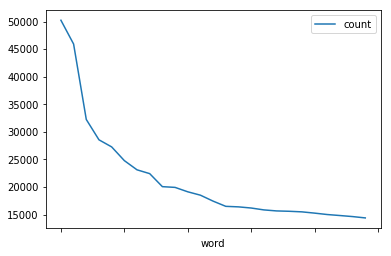

In [126]:
sorted_df.head(25).plot()

In [128]:
sorted_df.head(10)

,count
word,
one,50230
book,45916
good,32237
time,28548
even,27264
read,24778
movie,23107
first,22416
buy,20055


In [133]:
result_df.head(1)

,0,1,2,3,4,5,6,7,8,9
0,0.807868,0.192132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
transpose_df = result_df.transpose()


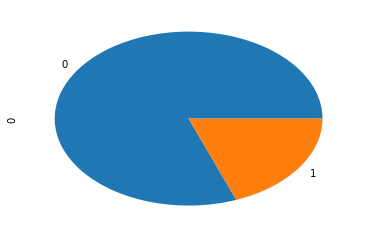

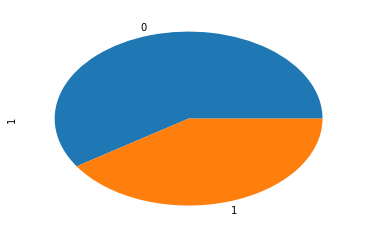

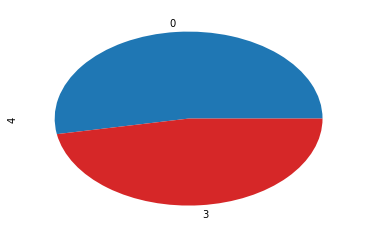

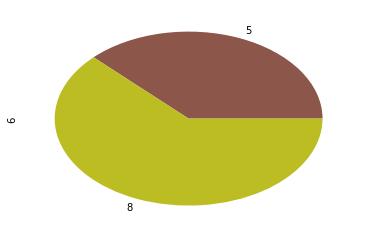

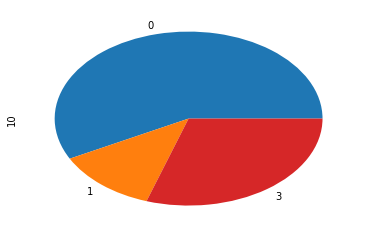

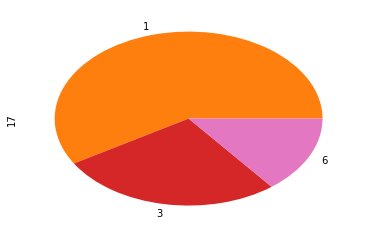

In [152]:
transpose_df.plot.pie(y=0, legend=False)
transpose_df.plot.pie(y=1, legend=False)
transpose_df.plot.pie(y=4, legend=False)
transpose_df.plot.pie(y=6, legend=False)
transpose_df.plot.pie(y=10, legend=False)
transpose_df.plot.pie(y=17, legend=False)